**ClickPost Submission**

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 3.5 MB/s eta 0:00:00


Valid 'order_delivered_date' entries: 1178784
Invalid 'order_delivered_date' entries: 0
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.393357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 43362101, number of used features: 9
[LightGBM] [Info] Start training from score 2.638342
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}
Best RMSE score:  1.0169262737677256
Validation RMSE: 1.0180


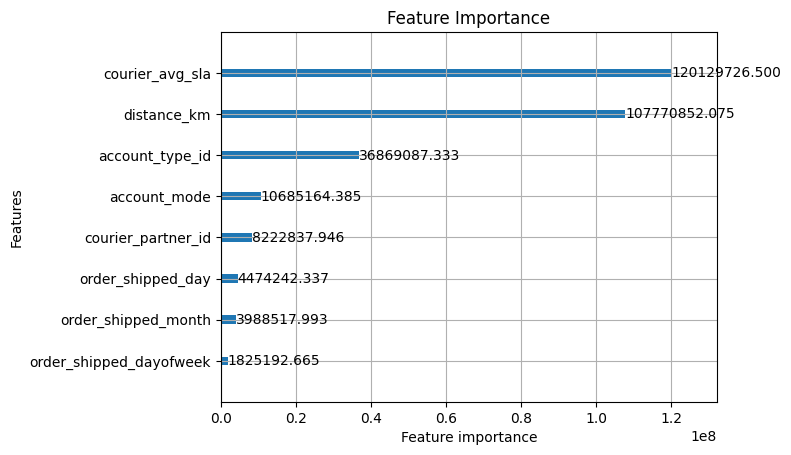

Submission file created successfully!


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading
# Load datasets, ensuring all data is read as strings to handle potential parsing issues
train = pd.read_csv('train_.csv', dtype=str, keep_default_na=False)
test = pd.read_csv('test_.csv', dtype=str, keep_default_na=False)
pincodes = pd.read_csv('pincodes.csv')

# 2. Data Preprocessing

# Identify and handle invalid 'order_delivered_date' entries
# We assume that the correct date format is 'YYYY-MM-DD'

# Check for invalid 'order_delivered_date' entries
train['order_delivered_date_valid'] = train['order_delivered_date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)

# Separate valid and invalid entries
train_valid = train[train['order_delivered_date_valid']].copy()
train_invalid = train[~train['order_delivered_date_valid']].copy()

print(f"Valid 'order_delivered_date' entries: {len(train_valid)}")
print(f"Invalid 'order_delivered_date' entries: {len(train_invalid)}")

# Option: Drop invalid entries
# Proceed only with valid data
train = train_valid.copy()

# Reset index
train.reset_index(drop=True, inplace=True)

# Convert date columns to datetime format
train['order_shipped_date'] = pd.to_datetime(train['order_shipped_date'], format='%Y-%m-%d', errors='coerce')
train['order_delivered_date'] = pd.to_datetime(train['order_delivered_date'], format='%Y-%m-%d', errors='coerce')
test['order_shipped_date'] = pd.to_datetime(test['order_shipped_date'], format='%Y-%m-%d', errors='coerce')

# Drop any rows in 'train' where date conversion failed (i.e., NaT values)
train.dropna(subset=['order_shipped_date', 'order_delivered_date'], inplace=True)
train.reset_index(drop=True, inplace=True)

# Calculate the exact_sla (target variable) for training data
train['exact_sla'] = (train['order_delivered_date'] - train['order_shipped_date']).dt.days

# Remove any rows with negative or unrealistic 'exact_sla'
train = train[train['exact_sla'] >= 0].copy()
train.reset_index(drop=True, inplace=True)

# 3. Merge Pincodes Data to Get Geographic Coordinates
# Adjust column names to match 'pincodes.csv'

# Prepare pincodes DataFrames for pickup and drop coordinates
pincodes_pickup = pincodes.rename(columns={
    'Pincode': 'pickup_pin_code',
    'Latitude': 'pickup_latitude',
    'Longitude': 'pickup_longitude'
})

pincodes_drop = pincodes.rename(columns={
    'Pincode': 'drop_pin_code',
    'Latitude': 'drop_latitude',
    'Longitude': 'drop_longitude'
})

# Convert 'pickup_pin_code' and 'drop_pin_code' in train and test to numeric
train['pickup_pin_code'] = pd.to_numeric(train['pickup_pin_code'], errors='coerce')
train['drop_pin_code'] = pd.to_numeric(train['drop_pin_code'], errors='coerce')
test['pickup_pin_code'] = pd.to_numeric(test['pickup_pin_code'], errors='coerce')
test['drop_pin_code'] = pd.to_numeric(test['drop_pin_code'], errors='coerce')

# Merge for pickup coordinates
train = pd.merge(train, pincodes_pickup[['pickup_pin_code', 'pickup_latitude', 'pickup_longitude']],
                 on='pickup_pin_code', how='left')
test = pd.merge(test, pincodes_pickup[['pickup_pin_code', 'pickup_latitude', 'pickup_longitude']],
                on='pickup_pin_code', how='left')

# Merge for drop coordinates
train = pd.merge(train, pincodes_drop[['drop_pin_code', 'drop_latitude', 'drop_longitude']],
                 on='drop_pin_code', how='left')
test = pd.merge(test, pincodes_drop[['drop_pin_code', 'drop_latitude', 'drop_longitude']],
                on='drop_pin_code', how='left')

# 4. Clean and Convert Coordinate Columns
coordinate_cols = ['pickup_longitude', 'pickup_latitude', 'drop_longitude', 'drop_latitude']

for col in coordinate_cols:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')

# Handle missing values in coordinate columns
train.dropna(subset=coordinate_cols, inplace=True)
train.reset_index(drop=True, inplace=True)

test.dropna(subset=coordinate_cols, inplace=True)
test.reset_index(drop=True, inplace=True)

# 5. Calculate Distance Between Pickup and Drop Locations
def haversine_distance_vectorized(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return c * r

# Calculate distance for train data
train['distance_km'] = haversine_distance_vectorized(
    train['pickup_longitude'], train['pickup_latitude'],
    train['drop_longitude'], train['drop_latitude']
)

# Calculate distance for test data
test['distance_km'] = haversine_distance_vectorized(
    test['pickup_longitude'], test['pickup_latitude'],
    test['drop_longitude'], test['drop_latitude']
)

# 6. Create Time-Based Features
# Use 'order_shipped_date'
train['order_shipped_dayofweek'] = train['order_shipped_date'].dt.dayofweek
train['order_shipped_month'] = train['order_shipped_date'].dt.month
train['order_shipped_day'] = train['order_shipped_date'].dt.day

test['order_shipped_dayofweek'] = test['order_shipped_date'].dt.dayofweek
test['order_shipped_month'] = test['order_shipped_date'].dt.month
test['order_shipped_day'] = test['order_shipped_date'].dt.day

# 7. Encoding Categorical Variables
# Combine train and test data for consistent encoding
train['train_test'] = 'train'
test['train_test'] = 'test'
df_combined = pd.concat([train, test], axis=0)

# List of categorical columns to encode
cat_cols = ['courier_partner_id', 'account_type_id', 'account_mode']

# Fill missing values in categorical columns with a placeholder
for col in cat_cols:
    df_combined[col] = df_combined[col].fillna('missing')

# Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    df_combined[col] = le.fit_transform(df_combined[col].astype(str))

# Split back into train and test
train = df_combined[df_combined['train_test'] == 'train'].drop('train_test', axis=1)
test = df_combined[df_combined['train_test'] == 'test'].drop(['train_test', 'exact_sla', 'order_delivered_date', 'order_delivered_date_valid'], axis=1)

# 8. Handle Missing Values in 'quantity' (if any)
train['quantity'] = pd.to_numeric(train['quantity'], errors='coerce').fillna(1).astype(int)
test['quantity'] = pd.to_numeric(test['quantity'], errors='coerce').fillna(1).astype(int)

# 9. Final Feature Selection
# Features to use for modeling
features = [
    'courier_partner_id',
    'account_type_id',
    'account_mode',
    'quantity',
    'distance_km',
    'order_shipped_dayofweek',
    'order_shipped_month',
    'order_shipped_day'
]

# Target variable
target = 'exact_sla'

# 10. Additional Feature Engineering (Optional)
# Add courier average SLA
# Calculate average 'exact_sla' per courier from training data
courier_performance = train.groupby('courier_partner_id')['exact_sla'].mean().reset_index()
courier_performance = courier_performance.rename(columns={'exact_sla': 'courier_avg_sla'})

# Merge with train and test data
train = pd.merge(train, courier_performance, on='courier_partner_id', how='left')
test = pd.merge(test, courier_performance, on='courier_partner_id', how='left')

# Fill missing values in test data with overall average
overall_avg_sla = train['exact_sla'].mean()
test['courier_avg_sla'] = test['courier_avg_sla'].fillna(overall_avg_sla)

# Add 'courier_avg_sla' to features list
features.append('courier_avg_sla')

# 11. Model Training
X = train[features]
y = train[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

# Perform Grid Search CV
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score: ", -grid_search.best_score_)

# 12. Evaluate the Model
# Predict on validation set
y_pred = grid_search.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE: {:.4f}".format(rmse))

# 13. Feature Importance
# Feature importance plot
best_model = grid_search.best_estimator_
lgb.plot_importance(best_model, max_num_features=20, importance_type='gain')
plt.title('Feature Importance')
plt.show()

# 14. Make Predictions on Test Data
X_test = test[features]
test['predicted_exact_sla'] = best_model.predict(X_test)

# Ensure predicted values are reasonable integers
test['predicted_exact_sla'] = np.round(test['predicted_exact_sla']).astype(int)
test['predicted_exact_sla'] = test['predicted_exact_sla'].apply(lambda x: x if x > 0 else 1)

# 15. Prepare Submission File
submission = test[['id', 'predicted_exact_sla']]
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")